<a href="https://colab.research.google.com/github/uncbiag/OAI_analysis_2/blob/main/notebooks/FullDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
# Remember to Restart runtime after installation

!pip install vtk
!pip install itkwidgets
!pip install itk
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install icon-registration==0.3.4
!git clone https://github.com/uncbiag/OAI_analysis_2

In [2]:
import numpy as np
import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

# Remove this once the pip package is available
import sys
# sys.path.append("./OAI_analysis_2/")
import oai_analysis
import oai_analysis.mesh_processing as mp
from oai_analysis.analysis_object import AnalysisObject

# To enable running the itkwidgets window on colab
# from google.colab import output
# output.enable_custom_widget_manager()

%matplotlib inline

In [10]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

Local metadata does not exists. Falling back to download.
atlas_fc.nii.gz
atlas_image.nii.gz
atlas_mask_step_10.nii.gz
atlas_tc.nii.gz
FC_probmap.nii.gz
image_preprocessed.nii.gz
TC_probmap.nii.gz


In [3]:
import os
import sys

test_volume = itk.imread(os.path.join("OAIData", "image_preprocessed.nii.gz"))

obj = AnalysisObject()
FC_prob, TC_prob = obj.segment(test_volume)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading parameter file = M:\Dev\Osteoarthritis\OAI_analysis_2\oai_analysis\data\models\segmentation_train_config.pth.tar
=> loading checkpoint 'M:\Dev\Osteoarthritis\OAI_analysis_2\oai_analysis\data\models\segmentation_model.pth.tar'
=> loaded checkpoint 'M:\Dev\Osteoarthritis\OAI_analysis_2\oai_analysis\data\models\segmentation_model.pth.tar' (epoch 600)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


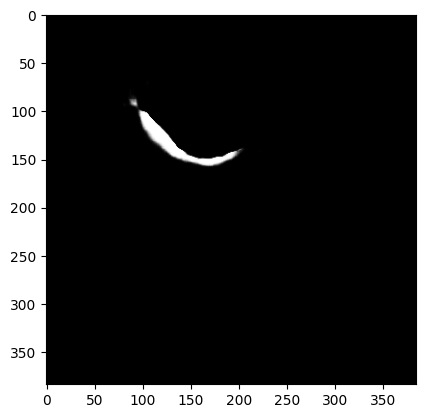

In [4]:
# Visualize the segmented FC probability map

plt.imshow(FC_prob[85], cmap='gray')

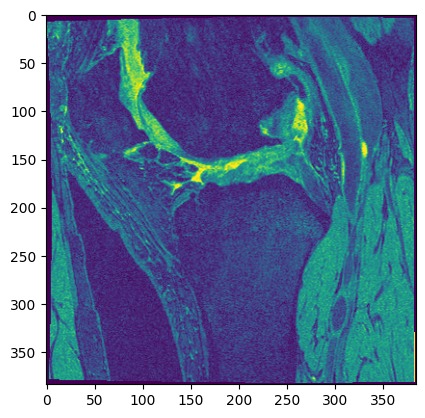

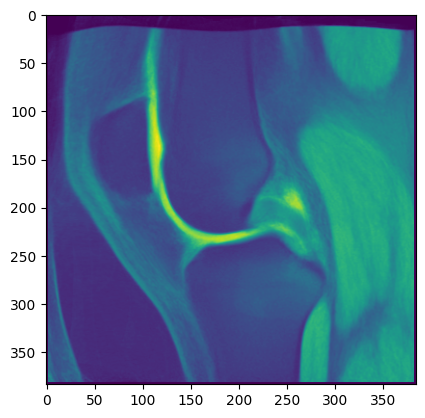

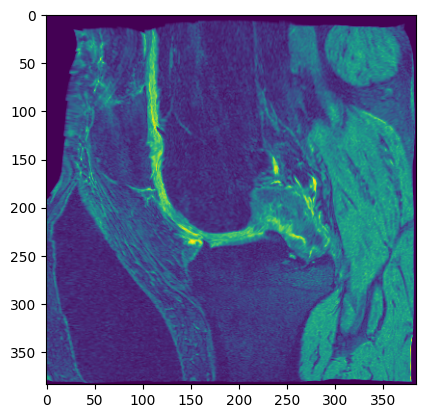

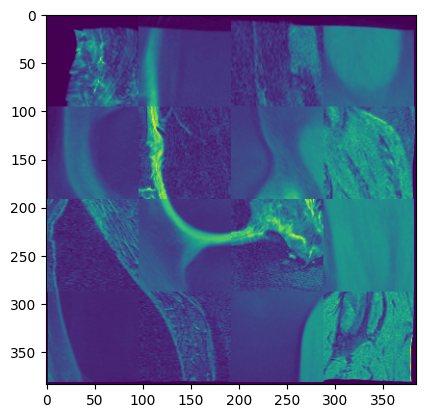

In [6]:
# Register the Atlas and the given image

model = pretrained_models.OAI_knees_registration_model()

image_A = itk.imread("OAIData/image_preprocessed.nii.gz", itk.D)
image_B = itk.imread("OAIData/atlas_image.nii.gz", itk.D)


# Register the images
phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)

interpolator = itk.LinearInterpolateImageFunction.New(image_A)
warped_image_A = itk.resample_image_filter(image_A, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


# Plot the images to check the alignment
checker_board = itk.checker_board_image_filter(warped_image_A, image_B)

plt.imshow(image_A[80])
plt.show()
plt.imshow(image_B[80])
plt.show()

plt.imshow(warped_image_A[80])
plt.show()

plt.imshow(itk.checker_board_image_filter(warped_image_A, image_B)[80])
plt.show()

In [7]:
# For deforming the FC and TC probability images using the transform obtained after registration

warped_image_FC = itk.resample_image_filter(FC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)


warped_image_TC = itk.resample_image_filter(TC_prob, 
    transform=phi_AB, 
    interpolator=interpolator,
    size=itk.size(image_B),
    output_spacing=itk.spacing(image_B),
    output_direction=image_B.GetDirection(),
    output_origin=image_B.GetOrigin()
)

print(warped_image_FC.shape)
print(warped_image_TC.shape)

(160, 384, 384)
(160, 384, 384)


In [8]:
# Get the thickness map for the meshes

distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [11]:
# Get inner and outer meshes for the TC and FC atlas meshes

prob_fc_atlas = itk.imread('./OAIData/atlas_fc.nii.gz')
mesh_fc_atlas = mp.get_mesh(prob_fc_atlas)
inner_mesh_fc_atlas, outer_mesh_fc_atlas = mp.split_mesh(mesh_fc_atlas, mesh_type='FC')

prob_tc_atlas = itk.imread('./OAIData/atlas_tc.nii.gz')
mesh_tc_atlas = mp.get_mesh(prob_tc_atlas)
inner_mesh_tc_atlas, outer_mesh_tc_atlas = mp.split_mesh(mesh_tc_atlas, mesh_type='TC')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [12]:
# For mapping the thickness to the atlas mesh

mapped_mesh_fc = mp.map_attributes(distance_inner_FC, inner_mesh_fc_atlas)
mapped_mesh_tc = mp.map_attributes(distance_inner_TC, inner_mesh_tc_atlas)

In [13]:
# Plot the 2D Thickness projection for TC

mesh_type = 'TC'
x, y, t = mp.project_thickness(mapped_mesh_tc, mesh_type=mesh_type)

s = plt.scatter(x, y, c=t, vmin=0, vmax=4)
cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()

InvalidParameterError: The 'degree' parameter of KernelPCA must be an int in the range [0, inf). Got 3.0 instead.

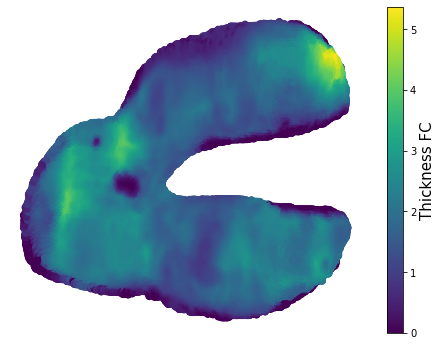

In [ ]:
# Plot the 2D Thickness projection for FC

mesh_type = 'FC'
x, y, t = mp.project_thickness(mapped_mesh_fc, mesh_type=mesh_type)

plt.figure(figsize=(8, 6))

s = plt.scatter(x, y, c=t)

cb = plt.colorbar(s)
cb.set_label('Thickness '+mesh_type, size=15)
plt.axis('off')
plt.draw()
plt.savefig('thickness_'+mesh_type+'.png')
plt.show()


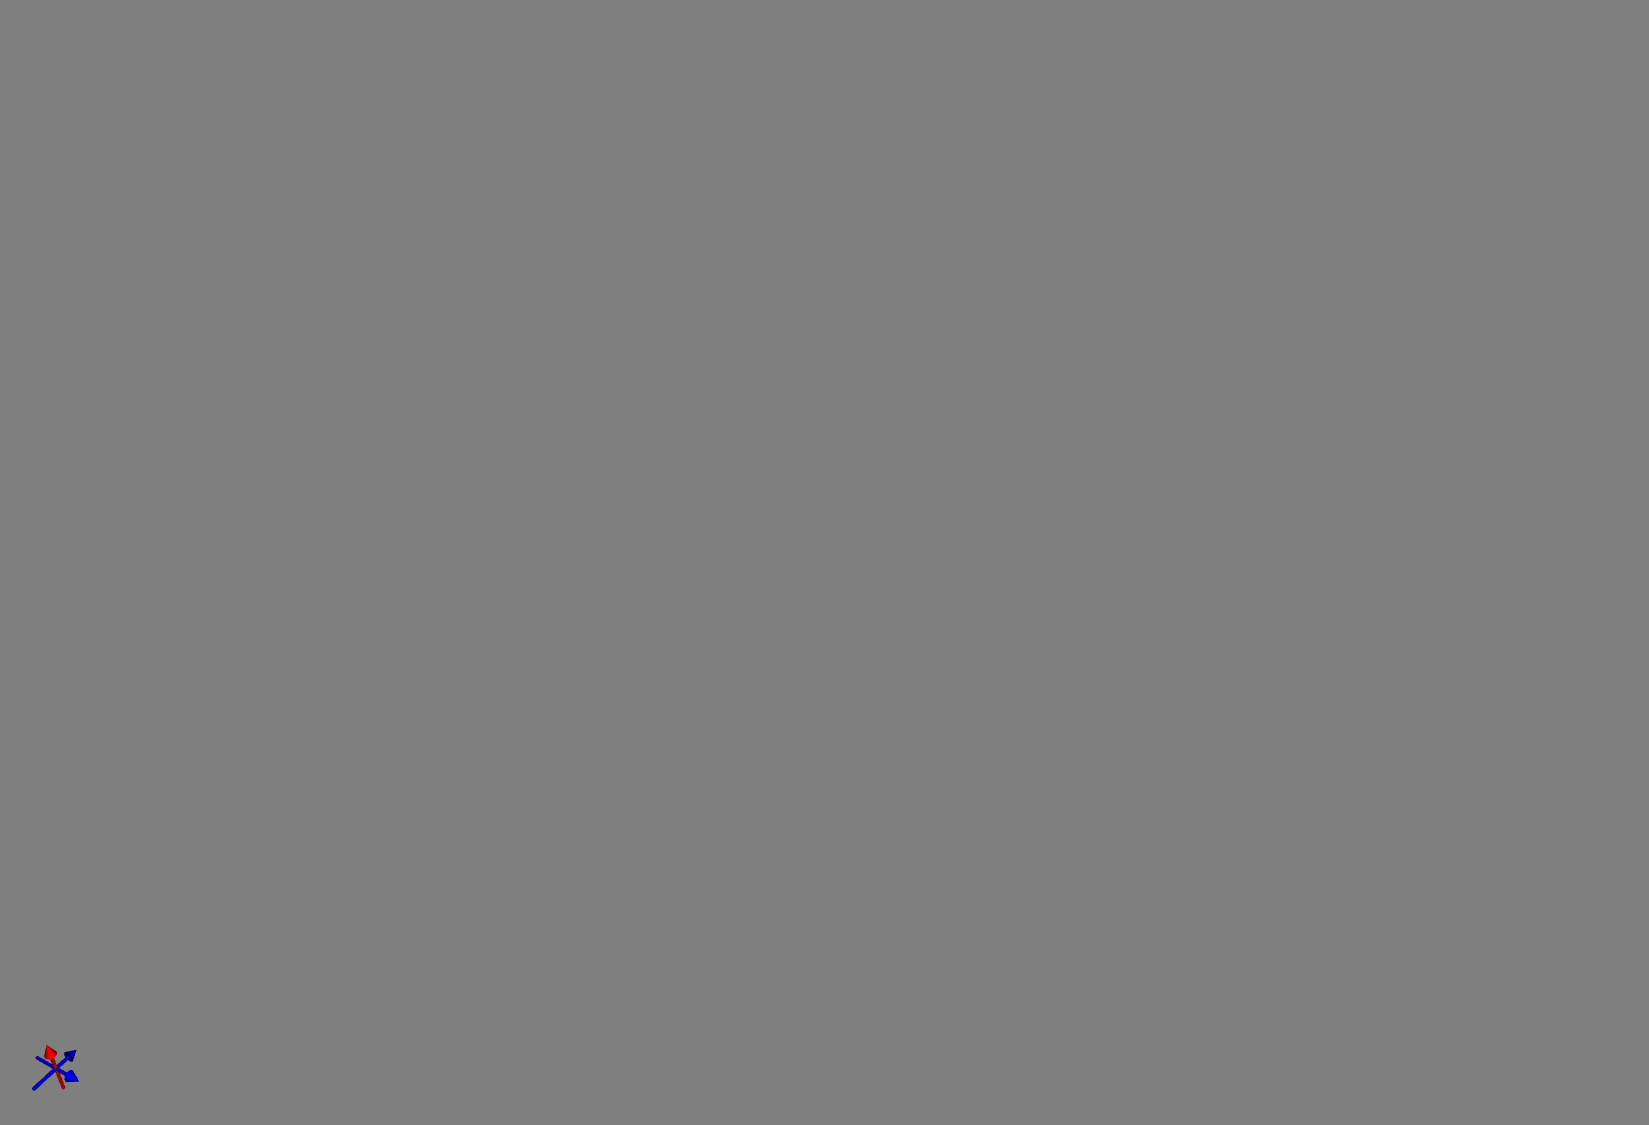
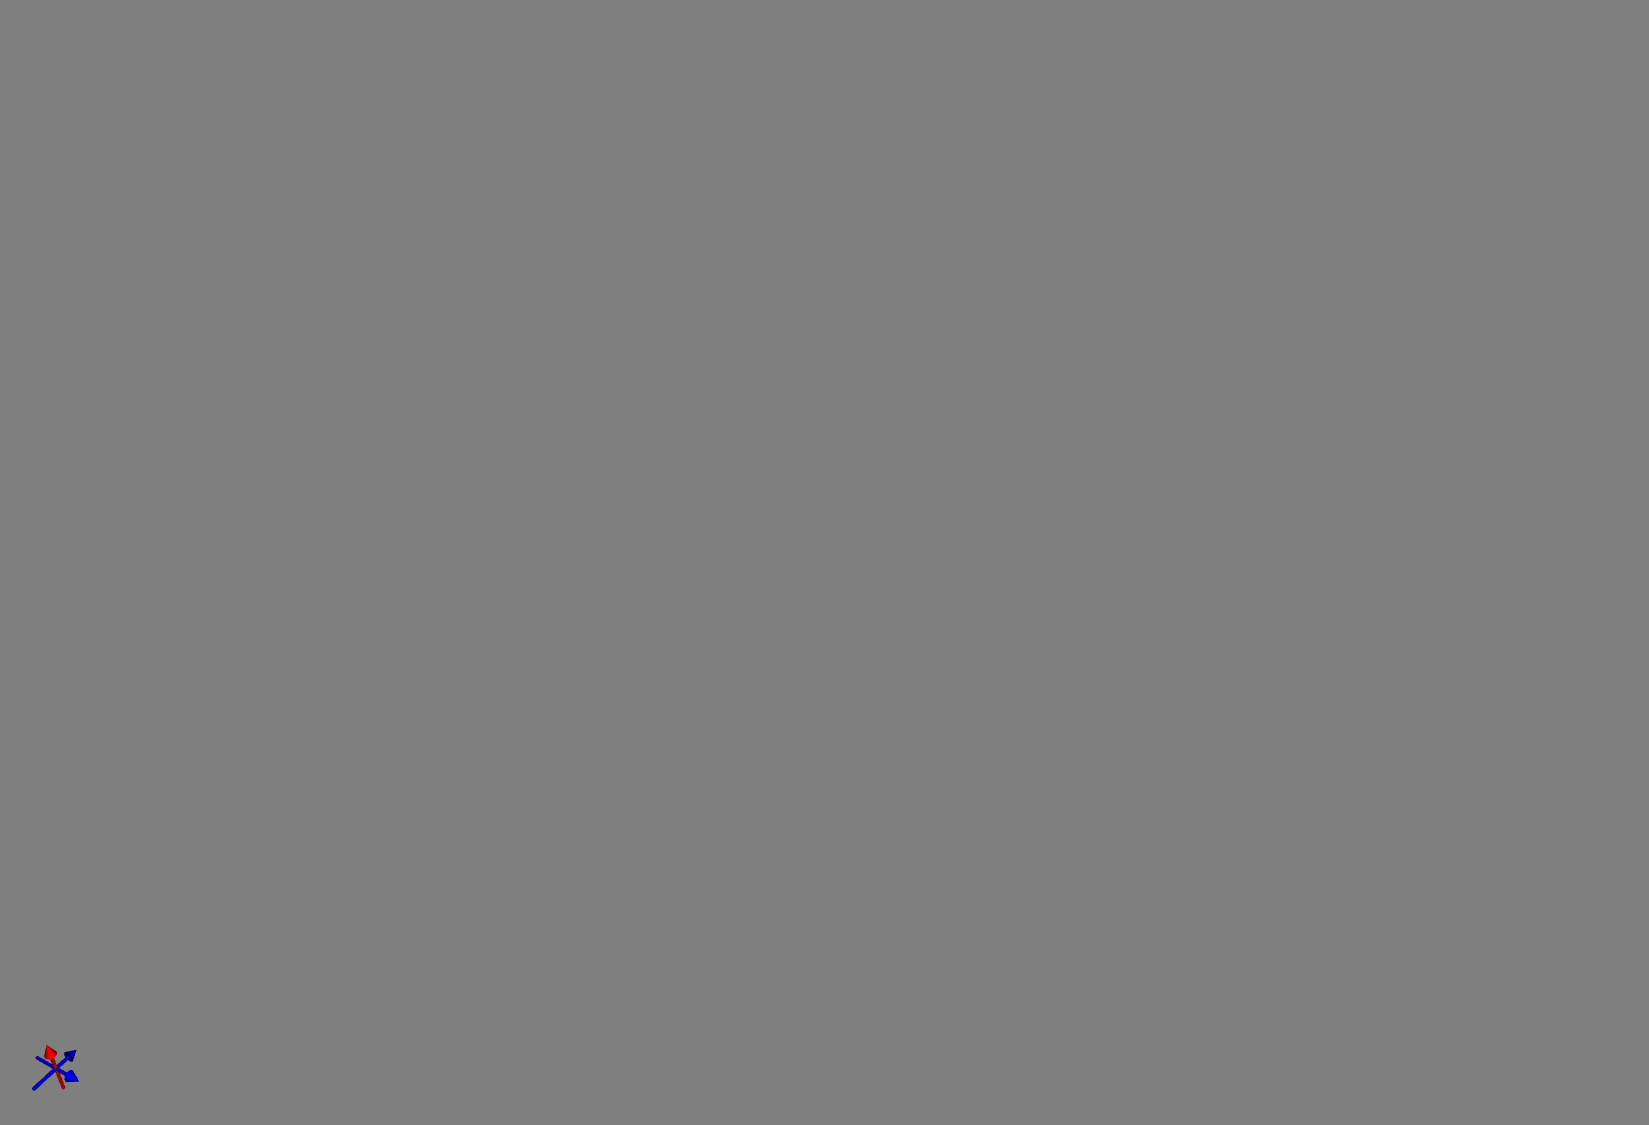

<IPython.core.display.Javascript object>

In [14]:
# Visualize the thickness map

view(geometries=[distance_inner_TC])

In [ ]:
# Visualize the thickness map

view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…